In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import functools
import gpflow as gpf
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensor_annotations.tensorflow as ttf
import tensorflow_probability as tfp

from gpflow import default_float, default_jitter
from gpflow.conditionals import uncertain_conditional, base_conditional
from matplotlib import cm
from numpy import random
from omegaconf import DictConfig
from simenvs import make

from modeopt.cost_functions import ControlQuadraticCostFunction, TargetStateCostFunction, StateDiffCostFunction, quadratic_cost_fn
from modeopt.controllers.utils import initialise_deterministic_trajectory, build_mode_variational_objective
from modeopt.controllers import TrajectoryOptimisationController
from modeopt.constraints import build_mode_chance_constraints_scipy
from modeopt.custom_types import Dataset
from modeopt.dynamics.conditionals import svgp_covariance_conditional
from modeopt.plotting import ModeOptContourPlotter
from modeopt.rollouts import rollout_controls_in_dynamics, rollout_controller_in_dynamics, rollout_controller_in_env, collect_data_from_env
from modeopt.trajectories import ControlTrajectoryDist
from modeopt.utils import model_from_DictConfig, combine_state_controls_to_input, append_zero_control
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Initialise environment

In [2]:
env_name = "velocity-controlled-point-mass/scenario-7"

In [3]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]
control_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


## ModeOpt config

In [4]:
start_state = np.array([[-1.0, -2.0]])
target_state = np.array([[1.7, 3.0]])
mode_satisfaction_prob = 0.8

## Sample initial data set from desired mode

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)


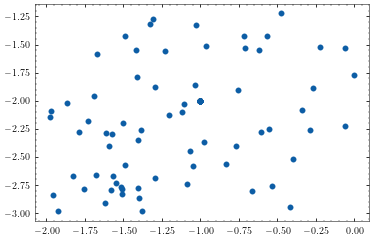

In [5]:
def sample_env_trajectories(horizon=15, num_trajectories=10):
    X, Y = [], []
    for i in range(num_trajectories):
        controls = np.random.uniform(
            env.action_spec().minimum,
            env.action_spec().maximum,
            (horizon, env.action_spec().shape[-1]),
        )
        X_, Y_ = collect_data_from_env(env, start_state=start_state, controls=controls)
        X.append(X_)
        Y.append(Y_)
    X = np.concatenate(X, 0)
    Y = np.concatenate(Y, 0)
    width = 1.0
    mask_1 = X[:, 0] > start_state[0, 0] - width
    mask_2 = X[:, 0] < start_state[0, 0] + width
    mask_3 = X[:, 1] > start_state[0, 1] - width
    mask_4 = X[:, 1] < start_state[0, 1] + width
    mask = mask_1 & mask_2 & mask_3 & mask_4
    X_trimmed = X[mask]
    Y_trimmed = Y[mask]
    print(X_trimmed.shape)
    print(Y_trimmed.shape)
    return (X_trimmed, Y_trimmed)

initial_dataset = sample_env_trajectories(horizon = 15, num_trajectories=50)
dataset = initial_dataset
plt.scatter(dataset[0][:, 0], dataset[0][:, 1])
plt.show()

## Train dynamics on initial data set or load from config

In [6]:
initial_num_epochs = 20000
# num_epochs = 300
num_epochs = 1500
# batch_size = 128
batch_size = initial_dataset[0].shape[0]
dynamics_logging_epoch_freq = 100

load_from_config = True
# load_from_config = False
yaml_cfg_filename = "./keras_configs/mode_opt_explore_scenario_7.yaml"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-29-18-14/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-13-33/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-14-22/ckpts"

In [7]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
log_dir = os.path.join(f"./experiments/bernoulli-without-conditioning/explorative-prob-{mode_satisfaction_prob}", now_time)

In [8]:
if load_from_config:
    mode_optimiser = ModeOpt.load(load_ckpt_dir)
    mode_optimiser.log_dir = log_dir
else:
    mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})
    mode_optimiser.dataset = (tf.constant(initial_dataset[0], dtype=default_float()),
                              tf.constant(initial_dataset[1], dtype=default_float())
                             )
    sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
    mode_optimiser.dynamics_fit_kwargs.update({"epochs": initial_num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     dynamics_plotting_callbacks = build_contour_plotter_callbacks(mode_optimiser.dynamics.mosvgpe, logging_epoch_freq=dynamics_logging_epoch_freq, log_dir=mode_optimiser.log_dir)
#     mode_optimiser.add_dynamics_callbacks(dynamics_plotting_callbacks)
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.inducing_variable, False)
    mode_optimiser.optimise_dynamics()
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

2022-04-08 17:35:01.304394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.4978003107997662                       │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kerne

2022-04-08 17:35:02.092529: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:35:02.092561: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:35:02.092799: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Update the data set.

In [9]:
mode_optimiser.start_state = tf.constant(start_state, dtype=default_float())

Set the correct desired dynamics mode.

In [10]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))
mode_optimiser.desired_mode = desired_mode

Desired mode is 1


Save the learned dynamics model.

In [11]:
mode_optimiser.save()

## Configure the explorative controller

In [12]:
horizon = 15
max_iterations = 1000
keep_last_solution = True
method = "SLSQP"

In [13]:
terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.001
# state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 1.0
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.1
control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.001
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 1.0

# terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=start_state)
terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=target_state)
control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
state_diff_cost_fn = StateDiffCostFunction(weight_matrix=state_diff_cost_matrix, target_state=target_state)

cost_fn = control_cost_fn + state_diff_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = control_cost_fn
# cost_fn = control_cost_fn + state_diff_cost_fn + terminal_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = terminal_cost_fn + state_diff_cost_fn

In [14]:
def explorative_objective(initial_solution: ControlTrajectoryDist) -> ttf.Tensor0:
    control_means = initial_solution(variance=False)
    control_vars = None
    state_means, state_vars = rollout_controls_in_dynamics(
        dynamics=mode_optimiser.dynamics,
        start_state=start_state,
        control_means=control_means,
        control_vars=control_vars,
    )
    h_means, h_vars = mode_optimiser.dynamics.uncertain_predict_gating(state_means[1:, :], control_means)
    mode_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs_given_h(h_means, h_vars)
    print("mode_probs.shape")
    print(mode_probs.shape)
    gating_entropy = tfd.Bernoulli(mode_probs[:, mode_optimiser.desired_mode]).entropy()
#     gating_entropy = tfd.Categorical(mode_probs).entropy()
    print(gating_entropy.shape)
#     h_dist = tfd.MultivariateNormalDiag(h_means, h_vars)
#     gating_entropy = h_dist.entropy()
    tf.print('entropy yo')
    tf.print(-tf.reduce_sum(gating_entropy))
    tf.print(cost_fn(state_means, control_means, state_vars, control_vars))
#     return -tf.reduce_sum(gating_entropy)
    return -tf.reduce_sum(gating_entropy) + cost_fn(state_means, control_means, state_vars, control_vars)

In [15]:
def find_initial_solution_in_desired_mode():
    fake_target_state_in_mode_idx = np.random.choice(np.arange(len(mode_optimiser.dataset[0])), size=1)
    fake_target_state_in_mode = mode_optimiser.dataset[0][fake_target_state_in_mode_idx[0], :state_dim]
    fake_target_state_in_mode = tf.constant([[0, -1]], dtype=default_float())
    
    terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100.0
    control_cost_matrix = tf.eye(control_dim, dtype=default_float())
    
    terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, 
                                               target_state=fake_target_state_in_mode)
    control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
    initial_cost_fn = terminal_cost_fn + control_cost_fn

    initial_solution = initialise_deterministic_trajectory(horizon, control_dim)
    objective_fn = build_mode_variational_objective(mode_optimiser.dynamics, initial_cost_fn, start_state)
    explorative_controller = TrajectoryOptimisationController(
        max_iterations=max_iterations,
        initial_solution=initial_solution,
        objective_fn=objective_fn,
        method=method,
    )
    explorative_controller.optimise()
    return explorative_controller.previous_solution

initial_solution_in_mode = find_initial_solution_in_desired_mode()

2022-04-08 17:35:03.195359: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Xnew.shape
(256, 15, 4)
gating_means.shape
(256, 15, 1)
input_mean.shape
(15, 4)
(15, 4)
var_exp: Tensor("Sum_218:0", shape=(15, 1), dtype=float64)
mode_var_exp: Tensor("Sum_219:0", shape=(), dtype=float64)


2022-04-08 17:35:44.947069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Optimisation result:
     fun: array([66.59696742])
     jac: array([2.69513992e-04, 7.56009729e-04, 5.53638984e-04, 6.17919925e-04,
       8.24734830e-05, 6.56961782e-04, 1.17365008e-04, 7.29399697e-04,
       4.05722417e-04, 7.39736557e-04, 4.61553437e-04, 6.91946622e-04,
       2.84344129e-04, 5.91346487e-04, 9.81022855e-05, 4.57220948e-04,
       7.90776870e-05, 4.21872280e-04, 1.69593489e-04, 5.53104525e-04,
       2.26450631e-04, 7.32156357e-04, 1.44979967e-04, 7.40807270e-04,
       7.21748549e-05, 4.30802069e-04, 1.85513109e-04, 2.63013167e-05,
       3.66076753e-04, 9.75111871e-05])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-0.23821481,  2.13424601, -0.13510465,  1.95088118, -0.07097346,
        1.82675821, -0.02716002,  1.7448613 ,  0.00669778,  1.69276623,
        0.03689614,  1.66185601,  0.0678676 ,  1.64643057,  0.10312259,
        1.6430313 ,  0.14580199,  1.65000104,  0.1990902 ,  

In [16]:
mode_chance_constraints = build_mode_chance_constraints_scipy(mode_optimiser.dynamics, 
                                                              start_state, 
                                                              horizon, 
                                                              control_dim=control_dim,
                                                              lower_bound=mode_satisfaction_prob)
explorative_controller = TrajectoryOptimisationController(
    max_iterations=max_iterations,
    initial_solution=initial_solution_in_mode,
    objective_fn=explorative_objective,
    keep_last_solution=keep_last_solution,
    constraints=[mode_chance_constraints],
    method=method,
)
mode_optimiser.explorative_controller = explorative_controller

## Configure plotter

In [17]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

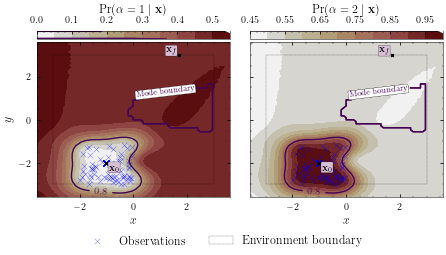

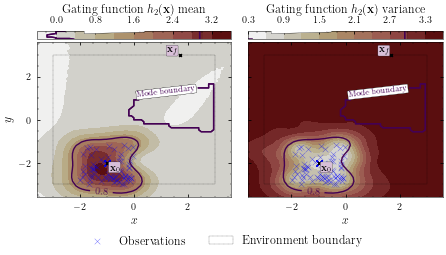

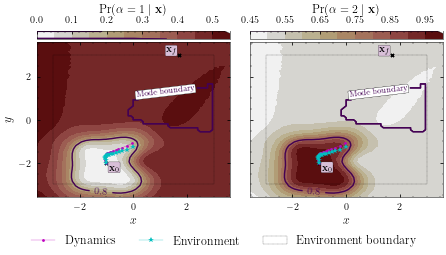

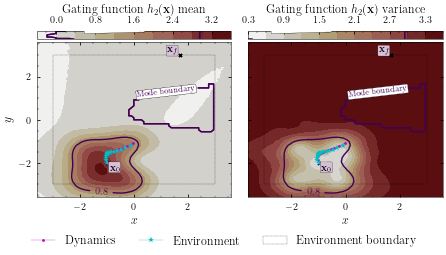

In [18]:
image_save_dir = os.path.join(mode_optimiser.log_dir, "images")
try:
    os.makedirs(image_save_dir)
except FileExistsError:
    pass

def plot_data_over_gating_network_and_save(step: int, epoch: int, save: bool = True):
    plotter.plot_data_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_mixing_probs_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_data_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_desired_gating_gp_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)

def plot_trajectories_over_gating_network_and_save(step: int, save: bool = True):
    plotter.plot_trajectories_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_mixing_probs_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_trajectories_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_desired_gating_gp_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)

plot_data_over_gating_network_and_save(step=0, epoch=0)
plot_trajectories_over_gating_network_and_save(step=0)

## Configure ModeOpt and callbacks

In [19]:
# mode_optimiser.dataset = (mode_optimiser.dataset[0][:130, :], mode_optimiser.dataset[1][:130, :])

In [20]:
# logging_epoch_freq = 60
num_epochs = 10000
logging_epoch_freq = math.floor((num_epochs)/5)
save_epoch_freq = math.floor((num_epochs)/5)
num_steps = 35
dataset = initial_dataset
# batch_size = 128
batch_size = mode_optimiser.dataset[0].shape[0]

mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
mode_optimiser.dynamics_fit_kwargs

{'epochs': 10000, 'batch_size': 125, 'validation_split': 0.2}

Callbacks for dynamics learning.

In [21]:
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
            plot_data_over_gating_network_and_save(step=step, epoch=epoch)

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(mode_optimiser.ckpt_dir, "step_{}_epoch_{}".format(step, epoch)), save_format="tf")
            
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=500,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callbacks = [PlottingCallback(),
             CustomSaver(),
             early_stopping_cb,
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

2022-04-08 17:36:28.780720: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:36:28.780737: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:36:28.780897: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [22]:
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
mode_optimiser.dynamics_callbacks = []
mode_optimiser.add_dynamics_callbacks(callbacks)

In [23]:
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.experts_list[desired_mode].gp.kernel, False)

mode_probs.shape
(15, 2)
(15,)
entropy yo
-8.8643939722958844
0.44419726434997742
entropy yo
-8.8640233658274816
0.44315863654668908
entropy yo
-8.91820056627268
0.43047564053765841
entropy yo
-9.1649711231799031
0.42000657346618425
entropy yo
-9.1057982103100965
0.42067801897286344
entropy yo
-9.1193786990773447
0.41765791888681192
entropy yo
-9.1314729868560534
0.412992031849358
entropy yo
-9.1406426361325117
0.40795238371341108
entropy yo
-9.1484865916548976
0.40217926330033182
entropy yo
-9.15107654843245
0.40043734398278891
entropy yo
-9.1587746721917043
0.39701132026996877
entropy yo
-9.1639514462657541
0.39817187920004271
entropy yo
-9.1675611379283772
0.39891706498602891
entropy yo
-9.1756945287261455
0.4007179115768536
entropy yo
-9.181499540625337
0.40127853417427695
entropy yo
-9.1817000442143275
0.39999010327182244
entropy yo
-9.1822761764133087
0.39804172587500092
entropy yo
-9.1821794516895849
0.39762031629253575
entropy yo
-9.1823996979642661
0.39589273300816447
entropy 

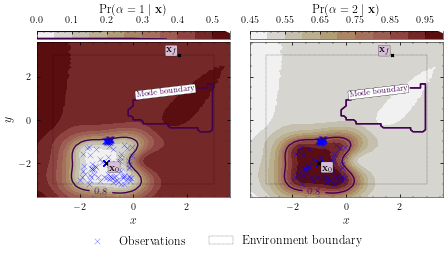

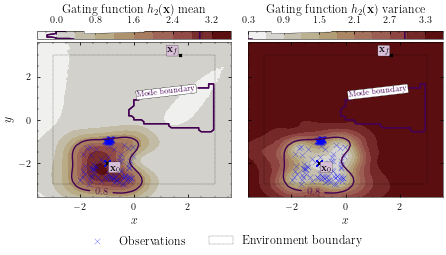

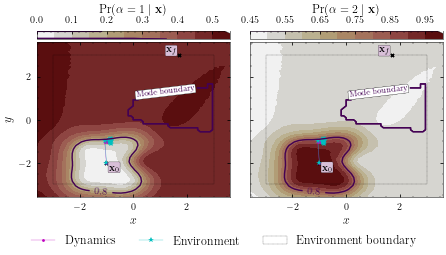

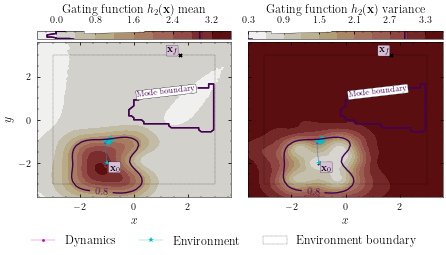

Epoch 1/10000
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (None, None, 2)
Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - ETA: 0s - loss: -653.3669Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - 20s 20s/step - loss: -653.3669 - val_loss: -623.6929
Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-35/ckpts/step_1_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - 0s 130ms/step - loss: -528.3567 - val_loss: -585.9078
Epoch 3/10000
1/1 [==============================] - 0s 28ms/step - loss: -627.9280 - val_loss: -666.1424
Epoch 4/10000
1/1 [==============================] - 0s 28ms/step - loss: -642.8833 - val_loss: -645.0948
Epoch 5/10000


2022-04-08 17:39:08.641389: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:39:08.641403: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:39:08.654033: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:39:08.674303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:39:08.690097: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_39_08

2022-04-08 17:39:08.700594: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_39_08/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:39:08.7

1/1 [==============================] - 0s 28ms/step - loss: -628.2597 - val_loss: -669.4485
Epoch 6/10000
1/1 [==============================] - 0s 29ms/step - loss: -628.5227 - val_loss: -606.5857
Epoch 7/10000
1/1 [==============================] - 0s 29ms/step - loss: -586.3421 - val_loss: -649.4288
Epoch 8/10000
1/1 [==============================] - 0s 28ms/step - loss: -647.3479 - val_loss: -677.3063
Epoch 9/10000
1/1 [==============================] - 0s 27ms/step - loss: -664.4915 - val_loss: -672.4216
Epoch 10/10000
1/1 [==============================] - 0s 28ms/step - loss: -670.4577 - val_loss: -720.1669
Epoch 11/10000
1/1 [==============================] - 0s 28ms/step - loss: -629.5966 - val_loss: -678.2106
Epoch 12/10000
1/1 [==============================] - 0s 29ms/step - loss: -634.3631 - val_loss: -681.0486
Epoch 13/10000
1/1 [==============================] - 0s 28ms/step - loss: -657.9947 - val_loss: -665.2179
Epoch 14/10000
1/1 [==============================] - 0s

Epoch 82/10000
1/1 [==============================] - 0s 27ms/step - loss: -740.5207 - val_loss: -821.0642
Epoch 83/10000
1/1 [==============================] - 0s 28ms/step - loss: -542.7230 - val_loss: -749.2963
Epoch 84/10000
1/1 [==============================] - 0s 27ms/step - loss: -676.8077 - val_loss: -707.3490
Epoch 85/10000
1/1 [==============================] - 0s 28ms/step - loss: -593.7424 - val_loss: -776.1252
Epoch 86/10000
1/1 [==============================] - 0s 27ms/step - loss: -532.3044 - val_loss: -826.0205
Epoch 87/10000
1/1 [==============================] - 0s 27ms/step - loss: -653.0744 - val_loss: -736.7104
Epoch 88/10000
1/1 [==============================] - 0s 28ms/step - loss: -678.5028 - val_loss: -765.3401
Epoch 89/10000
1/1 [==============================] - 0s 27ms/step - loss: -486.6873 - val_loss: -838.1233
Epoch 90/10000
1/1 [==============================] - 0s 27ms/step - loss: -663.3367 - val_loss: -528.2225
Epoch 91/10000
1/1 [=================

Epoch 158/10000
1/1 [==============================] - 0s 33ms/step - loss: -670.3084 - val_loss: -689.9391
Epoch 159/10000
1/1 [==============================] - 0s 32ms/step - loss: -569.6141 - val_loss: -431.9906
Epoch 160/10000
1/1 [==============================] - 0s 32ms/step - loss: -651.9568 - val_loss: -721.4753
Epoch 161/10000
1/1 [==============================] - 0s 31ms/step - loss: -654.9772 - val_loss: -679.9775
Epoch 162/10000
1/1 [==============================] - 0s 32ms/step - loss: -601.9035 - val_loss: -634.2653
Epoch 163/10000
1/1 [==============================] - 0s 34ms/step - loss: -649.7274 - val_loss: -719.7710
Epoch 164/10000
1/1 [==============================] - 0s 32ms/step - loss: -457.0766 - val_loss: -297.7126
Epoch 165/10000
1/1 [==============================] - 0s 30ms/step - loss: -612.5615 - val_loss: -581.6296
Epoch 166/10000
1/1 [==============================] - 0s 32ms/step - loss: -692.2965 - val_loss: -726.3409
Epoch 167/10000
1/1 [=======

Epoch 234/10000
1/1 [==============================] - 0s 35ms/step - loss: -647.7280 - val_loss: -782.4775
Epoch 235/10000
1/1 [==============================] - 0s 37ms/step - loss: 87.3871 - val_loss: -157.9575
Epoch 236/10000
1/1 [==============================] - 0s 34ms/step - loss: -496.5545 - val_loss: -695.5763
Epoch 237/10000
1/1 [==============================] - 0s 35ms/step - loss: -402.6891 - val_loss: -703.2495
Epoch 238/10000
1/1 [==============================] - 0s 35ms/step - loss: -692.4296 - val_loss: -718.2463
Epoch 239/10000
1/1 [==============================] - 0s 35ms/step - loss: -628.4760 - val_loss: -489.0769
Epoch 240/10000
1/1 [==============================] - 0s 36ms/step - loss: -228.8125 - val_loss: -725.1057
Epoch 241/10000
1/1 [==============================] - 0s 35ms/step - loss: -256.8079 - val_loss: -740.9674
Epoch 242/10000
1/1 [==============================] - 0s 35ms/step - loss: -647.5187 - val_loss: -703.3300
Epoch 243/10000
1/1 [=========

Epoch 310/10000
1/1 [==============================] - 0s 32ms/step - loss: -730.6837 - val_loss: -816.9371
Epoch 311/10000
1/1 [==============================] - 0s 33ms/step - loss: -755.6397 - val_loss: -829.8089
Epoch 312/10000
1/1 [==============================] - 0s 32ms/step - loss: -713.8602 - val_loss: -670.1136
Epoch 313/10000
1/1 [==============================] - 0s 43ms/step - loss: -746.9828 - val_loss: -799.3910
Epoch 314/10000
1/1 [==============================] - 0s 36ms/step - loss: -755.2684 - val_loss: -844.8830
Epoch 315/10000
1/1 [==============================] - 0s 34ms/step - loss: -729.2295 - val_loss: -831.5542
Epoch 316/10000
1/1 [==============================] - 0s 33ms/step - loss: -751.5643 - val_loss: -806.1932
Epoch 317/10000
1/1 [==============================] - 0s 33ms/step - loss: -755.4196 - val_loss: -818.0947
Epoch 318/10000
1/1 [==============================] - 0s 34ms/step - loss: -751.0016 - val_loss: -845.0784
Epoch 319/10000
1/1 [=======

1/1 [==============================] - 0s 48ms/step - loss: -411.8600 - val_loss: -633.9721
Epoch 387/10000
1/1 [==============================] - 0s 47ms/step - loss: -543.0548 - val_loss: -649.0064
Epoch 388/10000
1/1 [==============================] - 0s 46ms/step - loss: -561.2096 - val_loss: -664.5820
Epoch 389/10000
1/1 [==============================] - 0s 46ms/step - loss: -592.2478 - val_loss: -601.8615
Epoch 390/10000
1/1 [==============================] - 0s 47ms/step - loss: -579.3594 - val_loss: -649.1605
Epoch 391/10000
1/1 [==============================] - 0s 59ms/step - loss: -570.4601 - val_loss: -671.4599
Epoch 392/10000
1/1 [==============================] - 0s 66ms/step - loss: -400.9915 - val_loss: -360.4540
Epoch 393/10000
1/1 [==============================] - 0s 45ms/step - loss: -578.8942 - val_loss: -650.7967
Epoch 394/10000
1/1 [==============================] - 0s 44ms/step - loss: -557.4359 - val_loss: -636.0627
Epoch 395/10000
1/1 [=======================

1/1 [==============================] - 0s 55ms/step - loss: -732.3543 - val_loss: -765.6041
Epoch 463/10000
1/1 [==============================] - 0s 51ms/step - loss: -745.1895 - val_loss: -805.7366
Epoch 464/10000
1/1 [==============================] - 0s 55ms/step - loss: -755.2424 - val_loss: -808.7089
Epoch 465/10000
1/1 [==============================] - 0s 53ms/step - loss: -757.0607 - val_loss: -824.3237
Epoch 466/10000
1/1 [==============================] - 0s 55ms/step - loss: -743.2586 - val_loss: -811.8108
Epoch 467/10000
1/1 [==============================] - 0s 53ms/step - loss: -746.8026 - val_loss: -821.2943
Epoch 468/10000
1/1 [==============================] - 0s 53ms/step - loss: -779.8639 - val_loss: -828.9884
Epoch 469/10000
1/1 [==============================] - 0s 49ms/step - loss: -766.8127 - val_loss: -830.2792
Epoch 470/10000
1/1 [==============================] - 0s 52ms/step - loss: -775.9181 - val_loss: -783.2952
Epoch 471/10000
1/1 [=======================

1/1 [==============================] - 0s 61ms/step - loss: -143.5050 - val_loss: 167.3401
Epoch 539/10000
1/1 [==============================] - 0s 55ms/step - loss: -450.6206 - val_loss: -497.9691
Epoch 540/10000
1/1 [==============================] - 0s 54ms/step - loss: -614.1376 - val_loss: -480.6494
Epoch 541/10000
1/1 [==============================] - 0s 55ms/step - loss: -587.3475 - val_loss: -700.4816
Epoch 542/10000
1/1 [==============================] - 0s 75ms/step - loss: -452.7186 - val_loss: -476.1731
Epoch 543/10000
1/1 [==============================] - 0s 58ms/step - loss: -706.3988 - val_loss: -644.5945
Epoch 544/10000
1/1 [==============================] - 0s 55ms/step - loss: -436.9368 - val_loss: -800.2613
Epoch 545/10000
1/1 [==============================] - 0s 68ms/step - loss: -390.9851 - val_loss: -787.1064
Epoch 546/10000
1/1 [==============================] - 0s 54ms/step - loss: -580.5383 - val_loss: -832.7243
Epoch 547/10000
1/1 [========================

1/1 [==============================] - 0s 52ms/step - loss: -684.4118 - val_loss: -777.2673
Epoch 615/10000
1/1 [==============================] - 0s 55ms/step - loss: -719.3676 - val_loss: -722.8888
Epoch 616/10000
1/1 [==============================] - 0s 53ms/step - loss: -739.9929 - val_loss: -738.9157
Epoch 617/10000
1/1 [==============================] - 0s 54ms/step - loss: -605.7980 - val_loss: -643.7881
Epoch 618/10000
1/1 [==============================] - 0s 66ms/step - loss: -727.0542 - val_loss: -708.4154
Epoch 619/10000
1/1 [==============================] - 0s 55ms/step - loss: -753.3744 - val_loss: -816.2848
Epoch 620/10000
1/1 [==============================] - 0s 49ms/step - loss: -716.1588 - val_loss: -821.3331
Epoch 621/10000
1/1 [==============================] - 0s 49ms/step - loss: -755.4192 - val_loss: -767.2589
Epoch 622/10000
1/1 [==============================] - 0s 51ms/step - loss: -770.2122 - val_loss: -823.9357
Epoch 623/10000
1/1 [=======================

1/1 [==============================] - 0s 57ms/step - loss: -719.9809 - val_loss: -843.0185
Epoch 691/10000
1/1 [==============================] - 0s 88ms/step - loss: -487.5117 - val_loss: -776.3106
Epoch 692/10000
1/1 [==============================] - 0s 67ms/step - loss: -735.4184 - val_loss: -684.8977
Epoch 693/10000
1/1 [==============================] - 0s 63ms/step - loss: -732.1928 - val_loss: -836.4582
Epoch 694/10000
1/1 [==============================] - 0s 72ms/step - loss: -528.8395 - val_loss: -773.1198
Epoch 695/10000
1/1 [==============================] - 0s 68ms/step - loss: -356.5974 - val_loss: -691.1115
Epoch 696/10000
1/1 [==============================] - 0s 66ms/step - loss: -774.1684 - val_loss: -835.5130
Epoch 697/10000
1/1 [==============================] - 0s 60ms/step - loss: -744.3183 - val_loss: -840.9787
Epoch 698/10000
1/1 [==============================] - 0s 65ms/step - loss: -547.7981 - val_loss: -636.9910
Epoch 699/10000
1/1 [=======================

1/1 [==============================] - 0s 75ms/step - loss: -735.3827 - val_loss: -760.3979
Epoch 767/10000
1/1 [==============================] - 0s 84ms/step - loss: -674.0501 - val_loss: -726.3309
Epoch 768/10000
1/1 [==============================] - 0s 85ms/step - loss: -700.3345 - val_loss: -758.5802
Epoch 769/10000
1/1 [==============================] - 0s 75ms/step - loss: -649.4638 - val_loss: -717.4088
Epoch 770/10000
1/1 [==============================] - 0s 73ms/step - loss: -714.8488 - val_loss: -755.0380
Epoch 771/10000
1/1 [==============================] - 0s 82ms/step - loss: -538.9543 - val_loss: -693.3911
Epoch 772/10000
1/1 [==============================] - 0s 75ms/step - loss: -699.2613 - val_loss: -769.2705
Epoch 773/10000
1/1 [==============================] - 0s 76ms/step - loss: -447.2250 - val_loss: -700.1327
Epoch 774/10000
1/1 [==============================] - 0s 71ms/step - loss: -674.7266 - val_loss: -754.4064
Epoch 775/10000
1/1 [=======================

Epoch 842/10000
1/1 [==============================] - 0s 81ms/step - loss: -752.1198 - val_loss: -842.0979
Epoch 843/10000
1/1 [==============================] - 0s 65ms/step - loss: -645.3288 - val_loss: -750.2478
Epoch 844/10000
1/1 [==============================] - 0s 64ms/step - loss: -795.8315 - val_loss: -848.8683
Epoch 845/10000
1/1 [==============================] - 0s 65ms/step - loss: -682.2230 - val_loss: -843.0859
Epoch 846/10000
1/1 [==============================] - 0s 79ms/step - loss: -797.9289 - val_loss: -847.9635
Epoch 847/10000
1/1 [==============================] - 0s 72ms/step - loss: -823.4809 - val_loss: -868.1471
Epoch 848/10000
1/1 [==============================] - 0s 66ms/step - loss: -780.8665 - val_loss: -843.9746
Epoch 849/10000
1/1 [==============================] - 0s 66ms/step - loss: -775.6005 - val_loss: -863.0650
Epoch 850/10000
1/1 [==============================] - 0s 70ms/step - loss: -804.2301 - val_loss: -854.0502
Epoch 851/10000
1/1 [=======

Epoch 918/10000
1/1 [==============================] - 0s 86ms/step - loss: -601.4592 - val_loss: -632.8559
Epoch 919/10000
1/1 [==============================] - 0s 87ms/step - loss: -633.8789 - val_loss: -773.3125
Epoch 920/10000
1/1 [==============================] - 0s 89ms/step - loss: -552.4794 - val_loss: -426.6736
Epoch 921/10000
1/1 [==============================] - 0s 98ms/step - loss: -702.4076 - val_loss: -614.0896
Epoch 922/10000
1/1 [==============================] - 0s 90ms/step - loss: -655.6926 - val_loss: -741.2022
Epoch 923/10000
1/1 [==============================] - 0s 108ms/step - loss: -646.9218 - val_loss: -763.3379
Epoch 924/10000
1/1 [==============================] - 0s 89ms/step - loss: -525.1365 - val_loss: -719.1136
Epoch 925/10000
1/1 [==============================] - 0s 82ms/step - loss: -650.8583 - val_loss: -467.9608
Epoch 926/10000
1/1 [==============================] - 0s 86ms/step - loss: -473.8737 - val_loss: -467.9961
Epoch 927/10000
1/1 [======

1/1 [==============================] - 0s 70ms/step - loss: -785.9273 - val_loss: -855.8425
Epoch 994/10000
1/1 [==============================] - 0s 89ms/step - loss: -726.6928 - val_loss: -853.2348
Epoch 995/10000
1/1 [==============================] - 0s 126ms/step - loss: -685.4292 - val_loss: -792.7242
Epoch 996/10000
1/1 [==============================] - 0s 69ms/step - loss: -797.7201 - val_loss: -800.2850
Epoch 997/10000
1/1 [==============================] - 0s 70ms/step - loss: -561.0599 - val_loss: -820.5204
Epoch 998/10000
1/1 [==============================] - 0s 72ms/step - loss: -580.4364 - val_loss: -838.0912
Epoch 999/10000
1/1 [==============================] - 0s 71ms/step - loss: -757.9301 - val_loss: -759.5734
Epoch 1000/10000
1/1 [==============================] - 0s 68ms/step - loss: -714.5306 - val_loss: -751.9801
Epoch 1001/10000
1/1 [==============================] - 0s 70ms/step - loss: -254.5013 - val_loss: -205.2057
Epoch 1002/10000
1/1 [===================

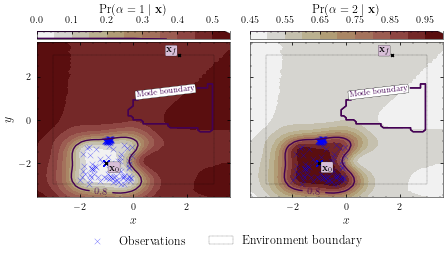

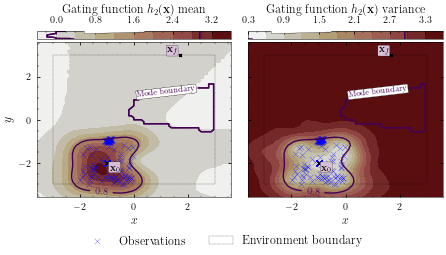

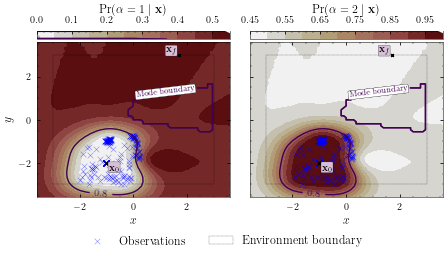

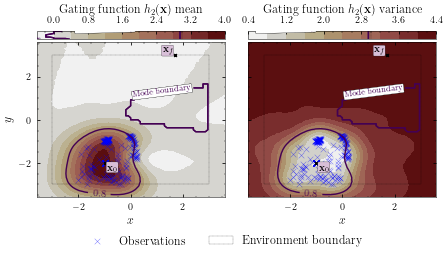

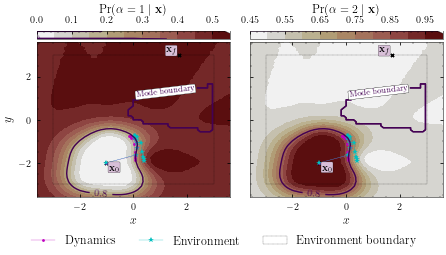

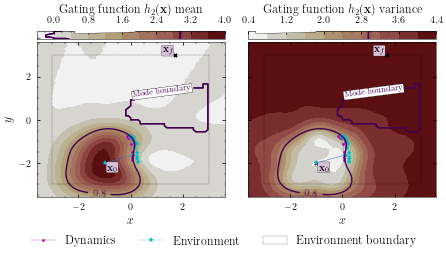

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: -738.9155 - val_loss: -699.8253
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-35/ckpts/step_2_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -692.3095

2022-04-08 17:43:34.865136: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:43:34.865156: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -692.3095 - val_loss: -727.5008
Epoch 3/10000
1/1 [==============================] - 0s 38ms/step - loss: -776.6442 - val_loss: -687.6219


2022-04-08 17:43:37.229943: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:43:37.249311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:43:37.263251: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_43_37

2022-04-08 17:43:37.276321: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_43_37/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:43:37.315282: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_43_37

2022-04-08 17

Epoch 4/10000
1/1 [==============================] - 0s 38ms/step - loss: -593.5849 - val_loss: -742.6066
Epoch 5/10000
1/1 [==============================] - 0s 38ms/step - loss: -721.8917 - val_loss: -691.3247
Epoch 6/10000
1/1 [==============================] - 0s 41ms/step - loss: -446.5646 - val_loss: -485.9031
Epoch 7/10000
1/1 [==============================] - 0s 44ms/step - loss: -662.5833 - val_loss: -741.1799
Epoch 8/10000
1/1 [==============================] - 0s 41ms/step - loss: -429.8449 - val_loss: -675.1748
Epoch 9/10000
1/1 [==============================] - 0s 38ms/step - loss: -769.2338 - val_loss: -627.8713
Epoch 10/10000
1/1 [==============================] - 0s 36ms/step - loss: -749.9207 - val_loss: -745.2951
Epoch 11/10000
1/1 [==============================] - 0s 37ms/step - loss: -738.5541 - val_loss: -607.9194
Epoch 12/10000
1/1 [==============================] - 0s 36ms/step - loss: -735.1473 - val_loss: -719.6294
Epoch 13/10000
1/1 [=======================

1/1 [==============================] - 0s 37ms/step - loss: -692.4450 - val_loss: -736.0789
Epoch 81/10000
1/1 [==============================] - 0s 37ms/step - loss: -780.4047 - val_loss: -759.2127
Epoch 82/10000
1/1 [==============================] - 0s 37ms/step - loss: -694.2902 - val_loss: -817.9141
Epoch 83/10000
1/1 [==============================] - 0s 37ms/step - loss: -758.7200 - val_loss: -809.6490
Epoch 84/10000
1/1 [==============================] - 0s 39ms/step - loss: -665.2807 - val_loss: -624.2938
Epoch 85/10000
1/1 [==============================] - 0s 37ms/step - loss: -788.4176 - val_loss: -697.4531
Epoch 86/10000
1/1 [==============================] - 0s 37ms/step - loss: -609.6894 - val_loss: -816.0690
Epoch 87/10000
1/1 [==============================] - 0s 36ms/step - loss: -750.3174 - val_loss: -815.2843
Epoch 88/10000
1/1 [==============================] - 0s 38ms/step - loss: -413.2241 - val_loss: -438.2433
Epoch 89/10000
1/1 [==============================] 

1/1 [==============================] - 0s 37ms/step - loss: -782.3245 - val_loss: -790.0004
Epoch 157/10000
1/1 [==============================] - 0s 38ms/step - loss: -695.5036 - val_loss: -695.0440
Epoch 158/10000
1/1 [==============================] - 0s 37ms/step - loss: -794.5178 - val_loss: -830.3600
Epoch 159/10000
1/1 [==============================] - 0s 38ms/step - loss: -820.1279 - val_loss: -764.4977
Epoch 160/10000
1/1 [==============================] - 0s 37ms/step - loss: -831.1932 - val_loss: -824.9686
Epoch 161/10000
1/1 [==============================] - 0s 38ms/step - loss: -805.9882 - val_loss: -829.7010
Epoch 162/10000
1/1 [==============================] - 0s 37ms/step - loss: -834.7255 - val_loss: -841.0003
Epoch 163/10000
1/1 [==============================] - 0s 37ms/step - loss: -754.9217 - val_loss: -792.6244
Epoch 164/10000
1/1 [==============================] - 0s 37ms/step - loss: -816.7440 - val_loss: -819.8033
Epoch 165/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -400.9859 - val_loss: -399.1496
Epoch 233/10000
1/1 [==============================] - 0s 41ms/step - loss: -618.4291 - val_loss: -613.8371
Epoch 234/10000
1/1 [==============================] - 0s 42ms/step - loss: -515.8953 - val_loss: -636.1178
Epoch 235/10000
1/1 [==============================] - 0s 43ms/step - loss: -642.0052 - val_loss: -679.4107
Epoch 236/10000
1/1 [==============================] - 0s 41ms/step - loss: -440.2206 - val_loss: -493.3900
Epoch 237/10000
1/1 [==============================] - 0s 45ms/step - loss: -601.3940 - val_loss: -671.9733
Epoch 238/10000
1/1 [==============================] - 0s 46ms/step - loss: -502.5523 - val_loss: -597.5045
Epoch 239/10000
1/1 [==============================] - 0s 44ms/step - loss: -685.1521 - val_loss: -555.2941
Epoch 240/10000
1/1 [==============================] - 0s 40ms/step - loss: -504.0723 - val_loss: -432.8376
Epoch 241/10000
1/1 [=======================

1/1 [==============================] - 0s 37ms/step - loss: -802.0615 - val_loss: -803.2820
Epoch 309/10000
1/1 [==============================] - 0s 37ms/step - loss: -777.1442 - val_loss: -798.2509
Epoch 310/10000
1/1 [==============================] - 0s 37ms/step - loss: -804.1668 - val_loss: -772.1338
Epoch 311/10000
1/1 [==============================] - 0s 37ms/step - loss: -793.1297 - val_loss: -755.6076
Epoch 312/10000
1/1 [==============================] - 0s 37ms/step - loss: -821.2982 - val_loss: -820.4270
Epoch 313/10000
1/1 [==============================] - 0s 37ms/step - loss: -821.0214 - val_loss: -823.6671
Epoch 314/10000
1/1 [==============================] - 0s 37ms/step - loss: -782.9734 - val_loss: -691.7635
Epoch 315/10000
1/1 [==============================] - 0s 37ms/step - loss: -750.0465 - val_loss: -814.2933
Epoch 316/10000
1/1 [==============================] - 0s 37ms/step - loss: -812.4735 - val_loss: -806.4442
Epoch 317/10000
1/1 [=======================

1/1 [==============================] - 0s 46ms/step - loss: -476.6234 - val_loss: -706.7514
Epoch 385/10000
1/1 [==============================] - 0s 43ms/step - loss: -109.5707 - val_loss: -590.0108
Epoch 386/10000
1/1 [==============================] - 0s 38ms/step - loss: -18.5156 - val_loss: -487.7418
Epoch 387/10000
1/1 [==============================] - 0s 38ms/step - loss: -190.7693 - val_loss: -585.6889
Epoch 388/10000
1/1 [==============================] - 0s 37ms/step - loss: 343.7750 - val_loss: 476.9325
Epoch 389/10000
1/1 [==============================] - 0s 38ms/step - loss: -485.1959 - val_loss: -623.4838
Epoch 390/10000
1/1 [==============================] - 0s 40ms/step - loss: 741.5614 - val_loss: 890.3497
Epoch 391/10000
1/1 [==============================] - 0s 40ms/step - loss: -318.1468 - val_loss: -213.7540
Epoch 392/10000
1/1 [==============================] - 0s 76ms/step - loss: 46.1573 - val_loss: -236.5623
Epoch 393/10000
1/1 [==============================

1/1 [==============================] - 0s 39ms/step - loss: -608.9468 - val_loss: -422.8535
Epoch 461/10000
1/1 [==============================] - 0s 40ms/step - loss: -666.6119 - val_loss: -636.2609
Epoch 462/10000
1/1 [==============================] - 0s 40ms/step - loss: -658.9191 - val_loss: -666.4444
Epoch 463/10000
1/1 [==============================] - 0s 39ms/step - loss: -610.5034 - val_loss: -565.1687
Epoch 464/10000
1/1 [==============================] - 0s 38ms/step - loss: -660.5919 - val_loss: -635.3610
Epoch 465/10000
1/1 [==============================] - 0s 40ms/step - loss: -588.7260 - val_loss: -617.4252
Epoch 466/10000
1/1 [==============================] - 0s 38ms/step - loss: -677.1603 - val_loss: -659.0073
Epoch 467/10000
1/1 [==============================] - 0s 39ms/step - loss: -640.4348 - val_loss: -554.3596
Epoch 468/10000
1/1 [==============================] - 0s 40ms/step - loss: -666.2231 - val_loss: -686.6740
Epoch 469/10000
1/1 [=======================

1/1 [==============================] - 0s 49ms/step - loss: -759.8682 - val_loss: -737.2630
Epoch 537/10000
1/1 [==============================] - 0s 45ms/step - loss: -804.4154 - val_loss: -806.3911
Epoch 538/10000
1/1 [==============================] - 0s 44ms/step - loss: -714.0919 - val_loss: -641.0023
Epoch 539/10000
1/1 [==============================] - 0s 42ms/step - loss: -746.2526 - val_loss: -607.3512
Epoch 540/10000
1/1 [==============================] - 0s 46ms/step - loss: -617.3892 - val_loss: -634.1719
Epoch 541/10000
1/1 [==============================] - 0s 44ms/step - loss: -784.7670 - val_loss: -755.7423
Epoch 542/10000
1/1 [==============================] - 0s 46ms/step - loss: -799.7761 - val_loss: -750.0683
Epoch 543/10000
1/1 [==============================] - 0s 42ms/step - loss: -762.5930 - val_loss: -719.0055
Epoch 544/10000
1/1 [==============================] - 0s 47ms/step - loss: -797.8250 - val_loss: -808.4505
Epoch 545/10000
1/1 [=======================

1/1 [==============================] - 0s 46ms/step - loss: -656.2845 - val_loss: -641.3986
Epoch 613/10000
1/1 [==============================] - 0s 41ms/step - loss: -531.2258 - val_loss: -639.9431
Epoch 614/10000
1/1 [==============================] - 0s 42ms/step - loss: -598.9452 - val_loss: -638.8124
Epoch 615/10000
1/1 [==============================] - 0s 43ms/step - loss: -286.7747 - val_loss: -346.4366
Epoch 616/10000
1/1 [==============================] - 0s 43ms/step - loss: 18.7795 - val_loss: 424.4947
Epoch 617/10000
1/1 [==============================] - 0s 44ms/step - loss: -395.4903 - val_loss: -459.5497
Epoch 618/10000
1/1 [==============================] - 0s 48ms/step - loss: 337.5568 - val_loss: -189.1025
Epoch 619/10000
1/1 [==============================] - 0s 45ms/step - loss: 184.9213 - val_loss: 457.3880
Epoch 620/10000
1/1 [==============================] - 0s 55ms/step - loss: -532.6451 - val_loss: -600.8841
Epoch 621/10000
1/1 [=============================

1/1 [==============================] - 0s 42ms/step - loss: -564.4488 - val_loss: -579.2996
Epoch 689/10000
1/1 [==============================] - 0s 43ms/step - loss: -483.2392 - val_loss: -492.8984
Epoch 690/10000
1/1 [==============================] - 0s 43ms/step - loss: -546.8703 - val_loss: -540.3247
Epoch 691/10000
1/1 [==============================] - 0s 42ms/step - loss: -591.6154 - val_loss: -504.7447
Epoch 692/10000
1/1 [==============================] - 0s 43ms/step - loss: -475.8754 - val_loss: -558.8059
Epoch 693/10000
1/1 [==============================] - 0s 42ms/step - loss: -579.0964 - val_loss: -517.8375
Epoch 694/10000
1/1 [==============================] - 0s 42ms/step - loss: -611.3247 - val_loss: -574.2210
Epoch 695/10000
1/1 [==============================] - 0s 43ms/step - loss: -555.0882 - val_loss: -602.8746
Epoch 696/10000
1/1 [==============================] - 0s 42ms/step - loss: -626.5311 - val_loss: -547.5525
Epoch 697/10000
1/1 [=======================

1/1 [==============================] - 0s 40ms/step - loss: -565.2073 - val_loss: -630.0510
Epoch 765/10000
1/1 [==============================] - 0s 40ms/step - loss: -639.5033 - val_loss: -643.6077
Epoch 766/10000
1/1 [==============================] - 0s 41ms/step - loss: -608.8662 - val_loss: -614.2647
Epoch 767/10000
1/1 [==============================] - 0s 41ms/step - loss: -563.5537 - val_loss: -567.3152
Epoch 768/10000
1/1 [==============================] - 0s 41ms/step - loss: -656.9910 - val_loss: -683.6352
Epoch 769/10000
1/1 [==============================] - 0s 41ms/step - loss: -624.1980 - val_loss: -659.2322
Epoch 770/10000
1/1 [==============================] - 0s 41ms/step - loss: -154.9154 - val_loss: -456.6352
Epoch 771/10000
1/1 [==============================] - 0s 41ms/step - loss: -574.8168 - val_loss: -577.6633
Epoch 772/10000
1/1 [==============================] - 0s 41ms/step - loss: -553.6422 - val_loss: -648.3540
Epoch 773/10000
1/1 [=======================

1/1 [==============================] - 0s 82ms/step - loss: -581.7286 - val_loss: -580.6225
Epoch 841/10000
1/1 [==============================] - 0s 62ms/step - loss: -364.3138 - val_loss: -429.4113
Epoch 842/10000
1/1 [==============================] - 0s 52ms/step - loss: -551.0147 - val_loss: -552.8859
Epoch 843/10000
1/1 [==============================] - 0s 42ms/step - loss: -433.5322 - val_loss: -414.1206
Epoch 844/10000
1/1 [==============================] - 0s 54ms/step - loss: -496.6647 - val_loss: -556.6111
Epoch 845/10000
1/1 [==============================] - 0s 45ms/step - loss: -554.1787 - val_loss: -535.2464
Epoch 846/10000
1/1 [==============================] - 0s 50ms/step - loss: -598.4818 - val_loss: -611.2365
Epoch 847/10000
1/1 [==============================] - 0s 44ms/step - loss: -574.0752 - val_loss: -598.0539
Epoch 848/10000
1/1 [==============================] - 0s 44ms/step - loss: -482.5086 - val_loss: -573.5278
Epoch 849/10000
1/1 [=======================

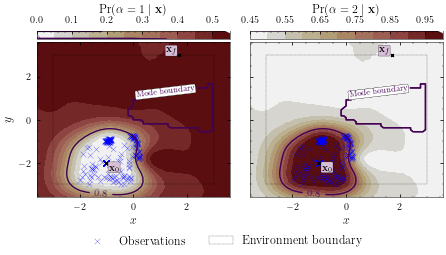

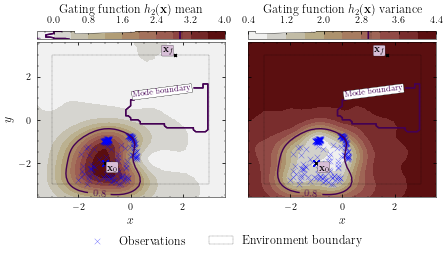

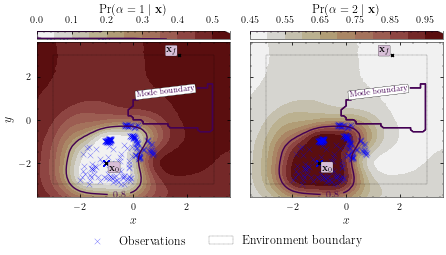

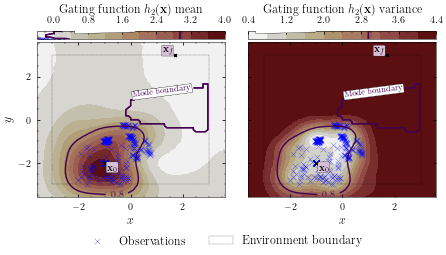

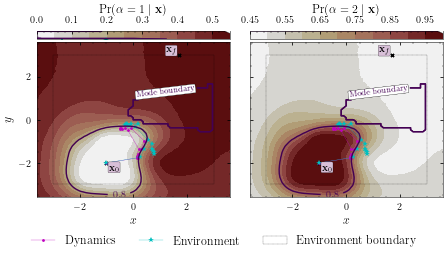

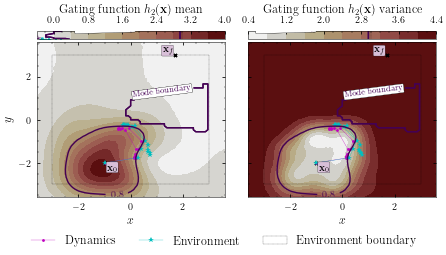

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: -503.6532 - val_loss: -498.0783
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-35/ckpts/step_3_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -563.4504

2022-04-08 17:48:13.119464: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:48:13.119488: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -563.4504 - val_loss: -432.9047
Epoch 3/10000
1/1 [==============================] - 0s 37ms/step - loss: -467.1378 - val_loss: -266.3381
Epoch 4/10000
1/1 [==============================] - 0s 39ms/step - loss: -555.4671 - val_loss: -437.4007


2022-04-08 17:48:15.392552: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:48:15.405820: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:48:15.415212: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_48_15

2022-04-08 17:48:15.424556: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_48_15/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:48:15.454662: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_48_15

2022-04-08 17

Epoch 5/10000
1/1 [==============================] - 0s 40ms/step - loss: -567.2980 - val_loss: -145.9430
Epoch 6/10000
1/1 [==============================] - 0s 46ms/step - loss: -551.4467 - val_loss: -364.4292
Epoch 7/10000
1/1 [==============================] - 0s 38ms/step - loss: -617.4261 - val_loss: -444.3391
Epoch 8/10000
1/1 [==============================] - 0s 38ms/step - loss: -510.8167 - val_loss: -112.6031
Epoch 9/10000
1/1 [==============================] - 0s 41ms/step - loss: -573.7699 - val_loss: -422.2581
Epoch 10/10000
1/1 [==============================] - 0s 38ms/step - loss: -623.4391 - val_loss: -520.5777
Epoch 11/10000
1/1 [==============================] - 0s 49ms/step - loss: -520.1297 - val_loss: -373.3639
Epoch 12/10000
1/1 [==============================] - 0s 68ms/step - loss: -541.3975 - val_loss: -422.6662
Epoch 13/10000
1/1 [==============================] - 0s 58ms/step - loss: -591.5674 - val_loss: -429.4323
Epoch 14/10000
1/1 [======================

1/1 [==============================] - 0s 72ms/step - loss: -681.2370 - val_loss: -621.9993
Epoch 82/10000
1/1 [==============================] - 0s 117ms/step - loss: -699.2660 - val_loss: -515.3543
Epoch 83/10000
1/1 [==============================] - 0s 83ms/step - loss: -685.1418 - val_loss: -363.1508
Epoch 84/10000
1/1 [==============================] - 0s 101ms/step - loss: -683.1099 - val_loss: -417.2528
Epoch 85/10000
1/1 [==============================] - 0s 142ms/step - loss: -672.7283 - val_loss: -401.5154
Epoch 86/10000
1/1 [==============================] - 0s 82ms/step - loss: -623.1092 - val_loss: -182.4659
Epoch 87/10000
1/1 [==============================] - 0s 155ms/step - loss: -407.6603 - val_loss: 54.2187
Epoch 88/10000
1/1 [==============================] - 0s 280ms/step - loss: -642.7402 - val_loss: -227.8775
Epoch 89/10000
1/1 [==============================] - 0s 218ms/step - loss: -466.9470 - val_loss: 21.0248
Epoch 90/10000
1/1 [==============================

1/1 [==============================] - 0s 80ms/step - loss: -247.8711 - val_loss: -545.5941
Epoch 158/10000
1/1 [==============================] - 0s 64ms/step - loss: -707.2067 - val_loss: -479.1337
Epoch 159/10000
1/1 [==============================] - 0s 68ms/step - loss: -625.2684 - val_loss: -586.4771
Epoch 160/10000
1/1 [==============================] - 0s 69ms/step - loss: -454.8570 - val_loss: -563.9039
Epoch 161/10000
1/1 [==============================] - 0s 64ms/step - loss: -583.2827 - val_loss: -527.9756
Epoch 162/10000
1/1 [==============================] - 0s 63ms/step - loss: -511.9933 - val_loss: -447.1001
Epoch 163/10000
1/1 [==============================] - 0s 68ms/step - loss: -637.1384 - val_loss: -421.4673
Epoch 164/10000
1/1 [==============================] - 0s 63ms/step - loss: -668.7083 - val_loss: -436.7683
Epoch 165/10000
1/1 [==============================] - 0s 67ms/step - loss: -294.6239 - val_loss: -191.7747
Epoch 166/10000
1/1 [=======================

1/1 [==============================] - 0s 114ms/step - loss: -627.4692 - val_loss: -493.3634
Epoch 234/10000
1/1 [==============================] - 0s 101ms/step - loss: -274.9262 - val_loss: -406.3919
Epoch 235/10000
1/1 [==============================] - 0s 99ms/step - loss: -657.4968 - val_loss: -426.3533
Epoch 236/10000
1/1 [==============================] - 0s 101ms/step - loss: -206.5770 - val_loss: -525.7532
Epoch 237/10000
1/1 [==============================] - 0s 92ms/step - loss: -620.2993 - val_loss: -420.5098
Epoch 238/10000
1/1 [==============================] - 0s 89ms/step - loss: -562.2003 - val_loss: -527.3638
Epoch 239/10000
1/1 [==============================] - 0s 86ms/step - loss: -590.4330 - val_loss: -301.0150
Epoch 240/10000
1/1 [==============================] - 0s 83ms/step - loss: -526.4513 - val_loss: 69.8060
Epoch 241/10000
1/1 [==============================] - 0s 99ms/step - loss: -476.6273 - val_loss: -492.1093
Epoch 242/10000
1/1 [======================

1/1 [==============================] - 0s 54ms/step - loss: -686.7035 - val_loss: -302.9428
Epoch 310/10000
1/1 [==============================] - 0s 53ms/step - loss: -667.3833 - val_loss: -283.8851
Epoch 311/10000
1/1 [==============================] - 0s 54ms/step - loss: -701.6562 - val_loss: -558.8957
Epoch 312/10000
1/1 [==============================] - 0s 53ms/step - loss: -625.5701 - val_loss: -376.0800
Epoch 313/10000
1/1 [==============================] - 0s 54ms/step - loss: -728.3068 - val_loss: -591.6103
Epoch 314/10000
1/1 [==============================] - 0s 52ms/step - loss: -682.4215 - val_loss: -604.6885
Epoch 315/10000
1/1 [==============================] - 0s 53ms/step - loss: -579.6767 - val_loss: -529.4553
Epoch 316/10000
1/1 [==============================] - 0s 52ms/step - loss: -711.2156 - val_loss: -658.7529
Epoch 317/10000
1/1 [==============================] - 0s 52ms/step - loss: -750.9753 - val_loss: -663.0851
Epoch 318/10000
1/1 [=======================

1/1 [==============================] - 0s 51ms/step - loss: -768.9742 - val_loss: -604.9148
Epoch 386/10000
1/1 [==============================] - 0s 53ms/step - loss: -755.6209 - val_loss: -576.8949
Epoch 387/10000
1/1 [==============================] - 0s 53ms/step - loss: -663.9978 - val_loss: -681.7468
Epoch 388/10000
1/1 [==============================] - 0s 51ms/step - loss: -578.0902 - val_loss: -171.1797
Epoch 389/10000
1/1 [==============================] - 0s 52ms/step - loss: -672.0141 - val_loss: -484.1845
Epoch 390/10000
1/1 [==============================] - 0s 51ms/step - loss: -740.6753 - val_loss: -439.2102
Epoch 391/10000
1/1 [==============================] - 0s 51ms/step - loss: -696.0288 - val_loss: -689.7345
Epoch 392/10000
1/1 [==============================] - 0s 52ms/step - loss: -753.0447 - val_loss: -661.0495
Epoch 393/10000
1/1 [==============================] - 0s 51ms/step - loss: -703.0282 - val_loss: -631.4943
Epoch 394/10000
1/1 [=======================

1/1 [==============================] - 0s 48ms/step - loss: -579.5753 - val_loss: -566.6745
Epoch 462/10000
1/1 [==============================] - 0s 48ms/step - loss: -621.7721 - val_loss: -557.0242
Epoch 463/10000
1/1 [==============================] - 0s 48ms/step - loss: -606.6609 - val_loss: -499.2767
Epoch 464/10000
1/1 [==============================] - 0s 51ms/step - loss: -629.6300 - val_loss: -576.9865
Epoch 465/10000
1/1 [==============================] - 0s 49ms/step - loss: -601.8004 - val_loss: -556.6437
Epoch 466/10000
1/1 [==============================] - 0s 52ms/step - loss: -619.5889 - val_loss: -463.2669
Epoch 467/10000
1/1 [==============================] - 0s 47ms/step - loss: -465.0912 - val_loss: -476.9809
Epoch 468/10000
1/1 [==============================] - 0s 48ms/step - loss: -573.4929 - val_loss: -485.1791
Epoch 469/10000
1/1 [==============================] - 0s 49ms/step - loss: -614.0816 - val_loss: -424.5877
Epoch 470/10000
1/1 [=======================

1/1 [==============================] - 0s 53ms/step - loss: -676.6068 - val_loss: -128.0618
Epoch 538/10000
1/1 [==============================] - 0s 52ms/step - loss: -705.9573 - val_loss: -408.4321
Epoch 539/10000
1/1 [==============================] - 0s 50ms/step - loss: -697.7135 - val_loss: -617.6610
Epoch 540/10000
1/1 [==============================] - 0s 51ms/step - loss: -725.1429 - val_loss: -586.3608
Epoch 541/10000
1/1 [==============================] - 0s 51ms/step - loss: -760.6601 - val_loss: -646.0682
Epoch 542/10000
1/1 [==============================] - 0s 51ms/step - loss: -698.2472 - val_loss: -610.5927
Epoch 543/10000
1/1 [==============================] - 0s 54ms/step - loss: -684.8632 - val_loss: -434.8763
Epoch 544/10000
1/1 [==============================] - 0s 53ms/step - loss: -647.5156 - val_loss: -407.7505
Epoch 545/10000
1/1 [==============================] - 0s 56ms/step - loss: -629.0712 - val_loss: -279.6231
Epoch 546/10000
1/1 [=======================

1/1 [==============================] - 0s 44ms/step - loss: -632.7942 - val_loss: -358.6657
Epoch 614/10000
1/1 [==============================] - 0s 43ms/step - loss: -603.5481 - val_loss: -203.5022
Epoch 615/10000
1/1 [==============================] - 0s 45ms/step - loss: -568.9746 - val_loss: -556.7962
Epoch 616/10000
1/1 [==============================] - 0s 47ms/step - loss: -670.8458 - val_loss: -481.9591
Epoch 617/10000
1/1 [==============================] - 0s 50ms/step - loss: -658.5042 - val_loss: -516.1980
Epoch 618/10000
1/1 [==============================] - 0s 50ms/step - loss: -577.0935 - val_loss: -357.2121
Epoch 619/10000
1/1 [==============================] - 0s 52ms/step - loss: -561.7525 - val_loss: -525.2971
Epoch 620/10000
1/1 [==============================] - 0s 52ms/step - loss: -641.8400 - val_loss: -572.3465
Epoch 621/10000
1/1 [==============================] - 0s 50ms/step - loss: -632.1965 - val_loss: -569.4423
Epoch 622/10000
1/1 [=======================

1/1 [==============================] - 0s 45ms/step - loss: -690.5717 - val_loss: -580.4682
Epoch 690/10000
1/1 [==============================] - 0s 45ms/step - loss: -673.1675 - val_loss: -233.2055
Epoch 691/10000
1/1 [==============================] - 0s 44ms/step - loss: -662.0743 - val_loss: -708.6983
Epoch 692/10000
1/1 [==============================] - 0s 45ms/step - loss: -719.8029 - val_loss: -535.8611
Epoch 693/10000
1/1 [==============================] - 0s 44ms/step - loss: -738.2485 - val_loss: -546.0489
Epoch 694/10000
1/1 [==============================] - 0s 48ms/step - loss: -725.1186 - val_loss: -544.6506
Epoch 695/10000
1/1 [==============================] - 0s 50ms/step - loss: -618.8716 - val_loss: -320.5952
Epoch 696/10000
1/1 [==============================] - 0s 51ms/step - loss: -780.6521 - val_loss: -687.8375
Epoch 697/10000
1/1 [==============================] - 0s 51ms/step - loss: -738.2500 - val_loss: -652.0147
Epoch 698/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -538.7561 - val_loss: -547.4753
Epoch 766/10000
1/1 [==============================] - 0s 45ms/step - loss: -607.5625 - val_loss: -624.1157
Epoch 767/10000
1/1 [==============================] - 0s 42ms/step - loss: -671.5578 - val_loss: -687.1637
Epoch 768/10000
1/1 [==============================] - 0s 42ms/step - loss: -709.9973 - val_loss: -392.6660
Epoch 769/10000
1/1 [==============================] - 0s 43ms/step - loss: -643.5007 - val_loss: -580.7997
Epoch 770/10000
1/1 [==============================] - 0s 46ms/step - loss: -595.5576 - val_loss: 210.3595
Epoch 771/10000
1/1 [==============================] - 0s 42ms/step - loss: -551.7166 - val_loss: -291.3150
Epoch 772/10000
1/1 [==============================] - 0s 45ms/step - loss: -513.3868 - val_loss: -337.3386
Epoch 773/10000
1/1 [==============================] - 0s 43ms/step - loss: -749.8021 - val_loss: -642.0858
Epoch 774/10000
1/1 [========================

1/1 [==============================] - 0s 48ms/step - loss: -647.9239 - val_loss: -549.6262
Epoch 842/10000
1/1 [==============================] - 0s 48ms/step - loss: -661.5265 - val_loss: -584.8866
Epoch 843/10000
1/1 [==============================] - 0s 47ms/step - loss: -648.6875 - val_loss: -514.3958
Epoch 844/10000
1/1 [==============================] - 0s 47ms/step - loss: -566.6355 - val_loss: -275.7643
Epoch 845/10000
1/1 [==============================] - 0s 49ms/step - loss: -631.2684 - val_loss: -514.8260
Epoch 846/10000
1/1 [==============================] - 0s 48ms/step - loss: -652.1533 - val_loss: -549.0060
Epoch 847/10000
1/1 [==============================] - 0s 49ms/step - loss: -629.1973 - val_loss: -280.9476
Epoch 848/10000
1/1 [==============================] - 0s 48ms/step - loss: -620.0387 - val_loss: -510.2242
Epoch 849/10000
1/1 [==============================] - 0s 47ms/step - loss: -664.9579 - val_loss: -497.9581
Epoch 850/10000
1/1 [=======================

-9.143458286506398
0.36680690354339429
entropy yo
-9.1421959053373314
0.365590620109868
entropy yo
-9.1418972486787418
0.3652915060151668
entropy yo
-9.14183998214327
0.36522847594719987
entropy yo
-9.1414457606692867
0.3647845990393831
entropy yo
-9.14103231192105
0.36428419402107243
entropy yo
-9.14033084761208
0.36336866822090591
entropy yo
-9.1394845879403839
0.36216616494174025
entropy yo
-9.1390085102062244
0.36082586674360617
entropy yo
-9.1387654679546184
0.36103728139531449
entropy yo
-9.1391361396995663
0.36126306792976909
entropy yo
-9.1391854918123183
0.36139682026699149
entropy yo
-9.1393759764682585
0.36154823729822144
entropy yo
-9.13946928269738
0.36157044627645291
entropy yo
-9.13932766142325
0.36147608060822867
entropy yo
-9.1390895149185187
0.361100108087747
entropy yo
-9.1386987421208072
0.36075222660480522
entropy yo
-9.1381892218613565
0.3597540407347008
entropy yo
-9.137381779339357
0.359258250964388
entropy yo
-9.1379524763830524
0.35875335661541929
entropy yo
-

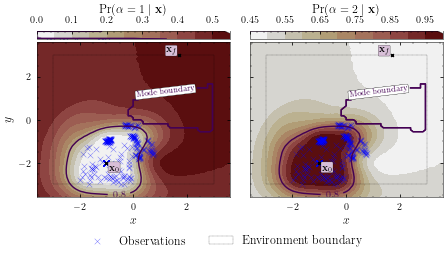

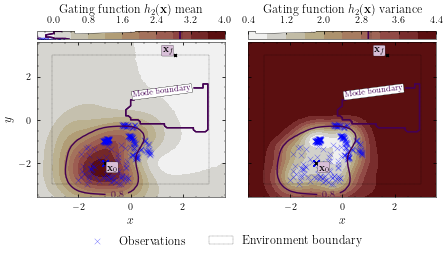

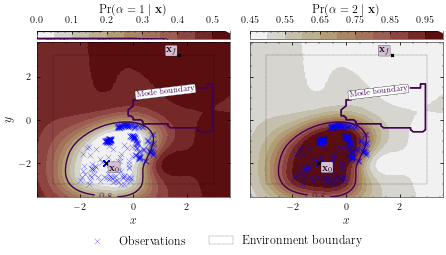

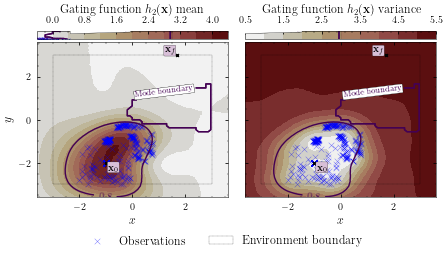

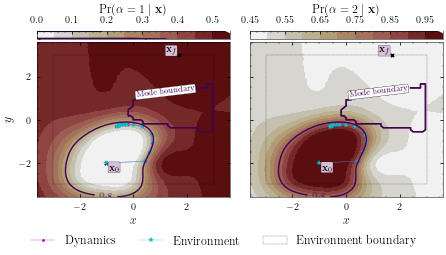

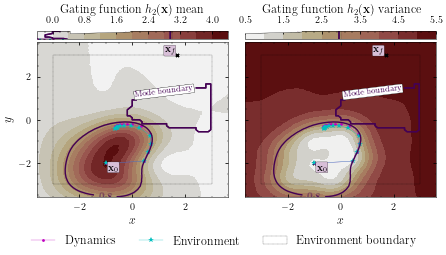

Epoch 1/10000
1/1 [==============================] - 5s 5s/step - loss: -709.3713 - val_loss: -583.1887
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-35/ckpts/step_4_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -652.4886

2022-04-08 17:54:03.185568: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:54:03.185596: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-08 17:54:06.941868: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 17:54:06.972854: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 17:54:06.995195: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_54_06

2022-04-08 17:54:07.011500: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_17_54_06/dr-robots-mbp.local.trace.json.gz
2022-04-08 17:54:07.0

1/1 [==============================] - 4s 4s/step - loss: -652.4886 - val_loss: -336.3656
Epoch 3/10000
1/1 [==============================] - 0s 73ms/step - loss: -651.7684 - val_loss: -374.4572
Epoch 4/10000
1/1 [==============================] - 0s 67ms/step - loss: -711.0746 - val_loss: -674.2101
Epoch 5/10000
1/1 [==============================] - 0s 68ms/step - loss: -699.4468 - val_loss: -602.8518
Epoch 6/10000
1/1 [==============================] - 0s 74ms/step - loss: -734.2296 - val_loss: -678.7924
Epoch 7/10000
1/1 [==============================] - 0s 66ms/step - loss: -644.5506 - val_loss: -361.2131
Epoch 8/10000
1/1 [==============================] - 0s 63ms/step - loss: -686.6939 - val_loss: -409.0031
Epoch 9/10000
1/1 [==============================] - 0s 70ms/step - loss: -615.9852 - val_loss: -41.2507
Epoch 10/10000
1/1 [==============================] - 0s 66ms/step - loss: -739.0092 - val_loss: -626.4466
Epoch 11/10000
1/1 [==============================] - 0s 67ms/

Epoch 79/10000
1/1 [==============================] - 0s 75ms/step - loss: -297.3322 - val_loss: -265.1279
Epoch 80/10000
1/1 [==============================] - 0s 76ms/step - loss: 63.6701 - val_loss: -455.4070
Epoch 81/10000
1/1 [==============================] - 0s 78ms/step - loss: -585.1579 - val_loss: -506.3369
Epoch 82/10000
1/1 [==============================] - 0s 79ms/step - loss: -671.4900 - val_loss: -507.9436
Epoch 83/10000
1/1 [==============================] - 0s 95ms/step - loss: -600.2027 - val_loss: -689.4567
Epoch 84/10000
1/1 [==============================] - 0s 74ms/step - loss: -593.9142 - val_loss: -477.4507
Epoch 85/10000
1/1 [==============================] - 0s 70ms/step - loss: -429.5784 - val_loss: -531.8298
Epoch 86/10000
1/1 [==============================] - 0s 75ms/step - loss: -173.7505 - val_loss: -375.6694
Epoch 87/10000
1/1 [==============================] - 0s 76ms/step - loss: -539.3227 - val_loss: -715.2711
Epoch 88/10000
1/1 [===================

1/1 [==============================] - 0s 46ms/step - loss: -714.1371 - val_loss: -713.0993
Epoch 156/10000
1/1 [==============================] - 0s 46ms/step - loss: -721.1822 - val_loss: -680.9626
Epoch 157/10000
1/1 [==============================] - 0s 46ms/step - loss: -691.4325 - val_loss: -722.9262
Epoch 158/10000
1/1 [==============================] - 0s 45ms/step - loss: -735.1700 - val_loss: -668.4583
Epoch 159/10000
1/1 [==============================] - 0s 47ms/step - loss: -628.1407 - val_loss: -677.1648
Epoch 160/10000
1/1 [==============================] - 0s 46ms/step - loss: -725.8268 - val_loss: -648.4619
Epoch 161/10000
1/1 [==============================] - 0s 46ms/step - loss: -727.6451 - val_loss: -724.9333
Epoch 162/10000
1/1 [==============================] - 0s 46ms/step - loss: -695.2780 - val_loss: -691.4683
Epoch 163/10000
1/1 [==============================] - 0s 46ms/step - loss: -583.8210 - val_loss: -582.0000
Epoch 164/10000
1/1 [=======================

Epoch 231/10000
1/1 [==============================] - 0s 64ms/step - loss: -764.4590 - val_loss: -747.1757
Epoch 232/10000
1/1 [==============================] - 0s 76ms/step - loss: -695.6425 - val_loss: -734.5685
Epoch 233/10000
1/1 [==============================] - 0s 68ms/step - loss: -735.0266 - val_loss: -736.2692
Epoch 234/10000
1/1 [==============================] - 0s 54ms/step - loss: -737.8806 - val_loss: -722.8935
Epoch 235/10000
1/1 [==============================] - 0s 61ms/step - loss: -717.3691 - val_loss: -462.0592
Epoch 236/10000
1/1 [==============================] - 0s 58ms/step - loss: -669.0466 - val_loss: -748.5418
Epoch 237/10000
1/1 [==============================] - 0s 48ms/step - loss: -738.4117 - val_loss: -773.1447
Epoch 238/10000
1/1 [==============================] - 0s 50ms/step - loss: -758.3739 - val_loss: -648.2830
Epoch 239/10000
1/1 [==============================] - 0s 86ms/step - loss: -773.4343 - val_loss: -695.3938
Epoch 240/10000
1/1 [=======

Epoch 307/10000
1/1 [==============================] - 0s 64ms/step - loss: -622.4849 - val_loss: -560.3353
Epoch 308/10000
1/1 [==============================] - 0s 61ms/step - loss: -588.9167 - val_loss: -713.0924
Epoch 309/10000
1/1 [==============================] - 0s 52ms/step - loss: -539.2215 - val_loss: -686.9078
Epoch 310/10000
1/1 [==============================] - 0s 62ms/step - loss: -688.1834 - val_loss: -636.1138
Epoch 311/10000
1/1 [==============================] - 0s 56ms/step - loss: -390.3167 - val_loss: -655.5092
Epoch 312/10000
1/1 [==============================] - 0s 50ms/step - loss: -709.8507 - val_loss: -693.6478
Epoch 313/10000
1/1 [==============================] - 0s 57ms/step - loss: -610.8865 - val_loss: -563.0312
Epoch 314/10000
1/1 [==============================] - 0s 49ms/step - loss: -603.6749 - val_loss: -648.7554
Epoch 315/10000
1/1 [==============================] - 0s 46ms/step - loss: -692.6626 - val_loss: -660.9471
Epoch 316/10000
1/1 [=======

Epoch 383/10000
1/1 [==============================] - 0s 47ms/step - loss: -650.4533 - val_loss: -436.9215
Epoch 384/10000
1/1 [==============================] - 0s 46ms/step - loss: -716.8584 - val_loss: -736.5002
Epoch 385/10000
1/1 [==============================] - 0s 48ms/step - loss: -627.0679 - val_loss: -447.0428
Epoch 386/10000
1/1 [==============================] - 0s 48ms/step - loss: -720.8480 - val_loss: -695.4216
Epoch 387/10000
1/1 [==============================] - 0s 50ms/step - loss: -686.8811 - val_loss: -690.3320
Epoch 388/10000
1/1 [==============================] - 0s 91ms/step - loss: -701.4074 - val_loss: -740.8510
Epoch 389/10000
1/1 [==============================] - 0s 57ms/step - loss: -737.5194 - val_loss: -746.7885
Epoch 390/10000
1/1 [==============================] - 0s 55ms/step - loss: -659.8324 - val_loss: -382.7245
Epoch 391/10000
1/1 [==============================] - 0s 67ms/step - loss: -729.8920 - val_loss: -749.9007
Epoch 392/10000
1/1 [=======

Epoch 459/10000
1/1 [==============================] - 0s 47ms/step - loss: -560.4950 - val_loss: -790.1153
Epoch 460/10000
1/1 [==============================] - 0s 47ms/step - loss: -755.1958 - val_loss: -748.5677
Epoch 461/10000
1/1 [==============================] - 0s 48ms/step - loss: -787.2415 - val_loss: -818.6871
Epoch 462/10000
1/1 [==============================] - 0s 47ms/step - loss: -667.8159 - val_loss: -793.7710
Epoch 463/10000
1/1 [==============================] - 0s 48ms/step - loss: -640.4310 - val_loss: -737.7267
Epoch 464/10000
1/1 [==============================] - 0s 47ms/step - loss: -759.6943 - val_loss: -767.4143
Epoch 465/10000
1/1 [==============================] - 0s 46ms/step - loss: -682.9230 - val_loss: -729.2622
Epoch 466/10000
1/1 [==============================] - 0s 45ms/step - loss: -700.9247 - val_loss: -264.3499
Epoch 467/10000
1/1 [==============================] - 0s 48ms/step - loss: -502.8503 - val_loss: -139.3087
Epoch 468/10000
1/1 [=======

Epoch 535/10000
1/1 [==============================] - 0s 51ms/step - loss: -729.8942 - val_loss: -716.2557
Epoch 536/10000
1/1 [==============================] - 0s 51ms/step - loss: -481.5665 - val_loss: -677.5994
Epoch 537/10000
1/1 [==============================] - 0s 57ms/step - loss: -786.2851 - val_loss: -777.6272
Epoch 538/10000
1/1 [==============================] - 0s 57ms/step - loss: -665.6699 - val_loss: -738.6849
Epoch 539/10000
1/1 [==============================] - 0s 59ms/step - loss: -788.9991 - val_loss: -795.2559
Epoch 540/10000
1/1 [==============================] - 0s 57ms/step - loss: -663.4880 - val_loss: -760.3060
Epoch 541/10000
1/1 [==============================] - 0s 85ms/step - loss: -649.1833 - val_loss: -708.8986
Epoch 542/10000
1/1 [==============================] - 0s 95ms/step - loss: -549.3744 - val_loss: -658.6104
Epoch 543/10000
1/1 [==============================] - 0s 59ms/step - loss: -723.3079 - val_loss: -786.0571
Epoch 544/10000
1/1 [=======

Epoch 611/10000
1/1 [==============================] - 0s 55ms/step - loss: -677.7480 - val_loss: -701.0075
Epoch 612/10000
1/1 [==============================] - 0s 58ms/step - loss: -639.4056 - val_loss: -591.4248
Epoch 613/10000
1/1 [==============================] - 0s 58ms/step - loss: -643.0740 - val_loss: -695.5798
Epoch 614/10000
1/1 [==============================] - 0s 57ms/step - loss: -565.0124 - val_loss: -536.3271
Epoch 615/10000
1/1 [==============================] - 0s 54ms/step - loss: -491.4808 - val_loss: -484.6820
Epoch 616/10000
1/1 [==============================] - 0s 53ms/step - loss: -356.9968 - val_loss: -442.4143
Epoch 617/10000
1/1 [==============================] - 0s 54ms/step - loss: -490.8820 - val_loss: -486.3180
Epoch 618/10000
1/1 [==============================] - 0s 54ms/step - loss: -637.1678 - val_loss: -656.1531
Epoch 619/10000
1/1 [==============================] - 0s 58ms/step - loss: -659.3857 - val_loss: -563.7619
Epoch 620/10000
1/1 [=======

Epoch 687/10000
1/1 [==============================] - 0s 54ms/step - loss: -539.6940 - val_loss: -600.0742
Epoch 688/10000
1/1 [==============================] - 0s 55ms/step - loss: -742.0226 - val_loss: -743.1985
Epoch 689/10000
1/1 [==============================] - 0s 55ms/step - loss: -732.9933 - val_loss: -715.0424
Epoch 690/10000
1/1 [==============================] - 0s 55ms/step - loss: -666.1108 - val_loss: -726.9613
Epoch 691/10000
1/1 [==============================] - 0s 68ms/step - loss: -717.4317 - val_loss: -666.7809
Epoch 692/10000
1/1 [==============================] - 0s 66ms/step - loss: -664.7087 - val_loss: -717.8114
Epoch 693/10000
1/1 [==============================] - 0s 61ms/step - loss: -717.0719 - val_loss: -658.7371
Epoch 694/10000
1/1 [==============================] - 0s 54ms/step - loss: -677.2262 - val_loss: -572.9511
Epoch 695/10000
1/1 [==============================] - 0s 57ms/step - loss: -759.4053 - val_loss: -758.6743
Epoch 696/10000
1/1 [=======

-9.1936768437520886
0.34293955560651163
entropy yo
-9.4511009155324039
1.659274366345165
entropy yo
-9.2948677567593165
0.355546732588009
entropy yo
-9.2040272115741448
0.342827071074433
entropy yo
-9.1842865697561979
0.3419074487057896
entropy yo
-9.1798367383149575
0.34092596166541028
entropy yo
-9.1791990884335384
0.34029792167639383
entropy yo
-9.1797231244049016
0.33991471660362055
entropy yo
-9.18125506508199
0.33970661006647956
entropy yo
-9.1807907127159147
0.33943570804730078
entropy yo
-9.1806950687892357
0.33845511979386994
entropy yo
-9.180067269126523
0.33770918830218832
entropy yo
-9.17959696156474
0.33714137029258018
entropy yo
-9.17912471614044
0.33646161198991831
entropy yo
-9.17876852398567
0.336094963860695
entropy yo
-9.1786929751316411
0.33600875124758689
entropy yo
-9.17874718050858
0.33601223418577275
entropy yo
-9.1788816995830675
0.33604168195515838
entropy yo
-9.1791225138788324
0.33607703417292834
entropy yo
-9.1794525879222864
0.33609065406282179
entropy yo


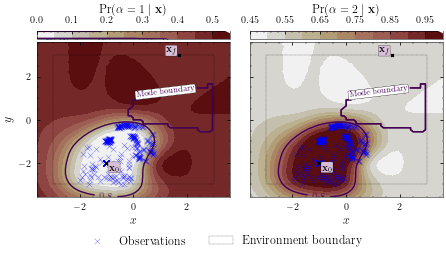

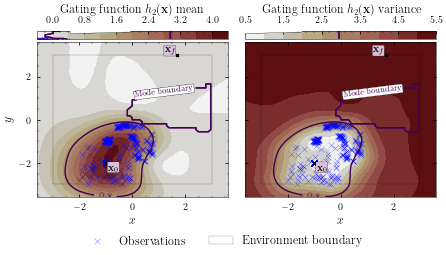

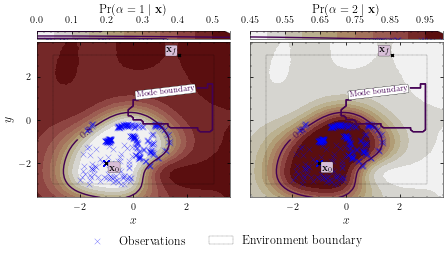

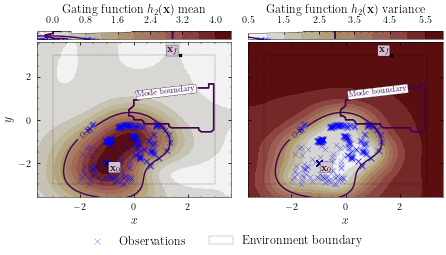

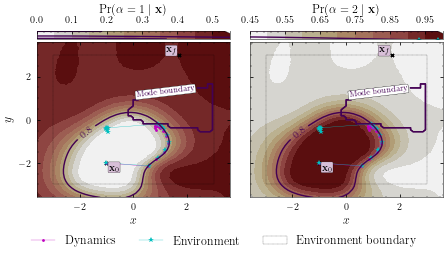

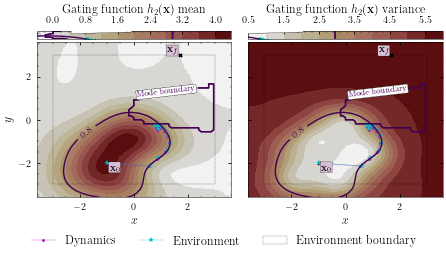

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: -743.2307 - val_loss: -432.8002
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-08-17-35/ckpts/step_5_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -783.7856

2022-04-08 17:59:58.600477: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-08 17:59:58.600495: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 2s 2s/step - loss: -783.7856 - val_loss: -419.8285


2022-04-08 18:00:00.858774: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-08 18:00:00.889207: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-08 18:00:00.910787: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_18_00_00

2022-04-08 18:00:00.926291: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_18_00_00/dr-robots-mbp.local.trace.json.gz
2022-04-08 18:00:00.980739: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/bernoulli-without-conditioning/explorative-prob-0.8/2022-04-08-17-35/train/plugins/profile/2022_04_08_18_00_00

2022-04-08 18

Epoch 3/10000
1/1 [==============================] - 0s 48ms/step - loss: -661.9319 - val_loss: -432.5019
Epoch 4/10000
1/1 [==============================] - 0s 53ms/step - loss: -642.4272 - val_loss: -488.1060
Epoch 5/10000
1/1 [==============================] - 0s 52ms/step - loss: -744.0319 - val_loss: -454.9289
Epoch 6/10000
1/1 [==============================] - 0s 42ms/step - loss: -678.7235 - val_loss: -274.1057
Epoch 7/10000
1/1 [==============================] - 0s 38ms/step - loss: -740.3084 - val_loss: -608.7391
Epoch 8/10000
1/1 [==============================] - 0s 40ms/step - loss: -716.2393 - val_loss: -400.8373
Epoch 9/10000
1/1 [==============================] - 0s 41ms/step - loss: -743.8075 - val_loss: -300.7417
Epoch 10/10000
1/1 [==============================] - 0s 43ms/step - loss: -813.3204 - val_loss: -630.5887
Epoch 11/10000
1/1 [==============================] - 0s 43ms/step - loss: -741.9239 - val_loss: -431.8844
Epoch 12/10000
1/1 [========================

1/1 [==============================] - 0s 49ms/step - loss: -775.3176 - val_loss: -553.6914
Epoch 80/10000
1/1 [==============================] - 0s 51ms/step - loss: -813.6317 - val_loss: -612.7929
Epoch 81/10000
1/1 [==============================] - 0s 48ms/step - loss: -740.1890 - val_loss: -547.7073
Epoch 82/10000
1/1 [==============================] - 0s 50ms/step - loss: -730.1657 - val_loss: -487.5846
Epoch 83/10000
1/1 [==============================] - 0s 49ms/step - loss: -293.0061 - val_loss: -100.8184
Epoch 84/10000
1/1 [==============================] - 0s 50ms/step - loss: -684.7307 - val_loss: -570.4687
Epoch 85/10000
1/1 [==============================] - 0s 50ms/step - loss: -804.2659 - val_loss: -598.3519
Epoch 86/10000
1/1 [==============================] - 0s 50ms/step - loss: -805.2639 - val_loss: -584.4692
Epoch 87/10000
1/1 [==============================] - 0s 50ms/step - loss: -670.3468 - val_loss: -559.4867
Epoch 88/10000
1/1 [==============================] 

1/1 [==============================] - 0s 50ms/step - loss: -631.4048 - val_loss: -493.5521
Epoch 156/10000
1/1 [==============================] - 0s 53ms/step - loss: -653.5587 - val_loss: -580.3344
Epoch 157/10000
1/1 [==============================] - 0s 50ms/step - loss: -594.0203 - val_loss: -505.7221
Epoch 158/10000
1/1 [==============================] - 0s 54ms/step - loss: -755.1050 - val_loss: -519.4038
Epoch 159/10000
1/1 [==============================] - 0s 55ms/step - loss: -639.3016 - val_loss: -517.3920
Epoch 160/10000
1/1 [==============================] - 0s 53ms/step - loss: -709.1986 - val_loss: -516.9749
Epoch 161/10000
1/1 [==============================] - 0s 50ms/step - loss: -482.8644 - val_loss: -442.6828
Epoch 162/10000
1/1 [==============================] - 0s 52ms/step - loss: -662.7065 - val_loss: -574.4323
Epoch 163/10000
1/1 [==============================] - 0s 51ms/step - loss: -694.0393 - val_loss: -445.2315
Epoch 164/10000
1/1 [=======================

1/1 [==============================] - 0s 59ms/step - loss: -672.0686 - val_loss: -545.5628
Epoch 232/10000
1/1 [==============================] - 0s 52ms/step - loss: -432.8542 - val_loss: -380.6349
Epoch 233/10000
1/1 [==============================] - 0s 52ms/step - loss: -693.0361 - val_loss: -503.6456
Epoch 234/10000
1/1 [==============================] - 0s 56ms/step - loss: -679.6088 - val_loss: -533.4856
Epoch 235/10000
1/1 [==============================] - 0s 59ms/step - loss: -623.3964 - val_loss: -448.7707
Epoch 236/10000
1/1 [==============================] - 0s 64ms/step - loss: -664.1921 - val_loss: -540.4460
Epoch 237/10000
1/1 [==============================] - 0s 62ms/step - loss: -472.6610 - val_loss: -444.6041
Epoch 238/10000
1/1 [==============================] - 0s 66ms/step - loss: -680.1688 - val_loss: -449.3942
Epoch 239/10000
1/1 [==============================] - 0s 65ms/step - loss: -622.0027 - val_loss: -544.2668
Epoch 240/10000
1/1 [=======================

1/1 [==============================] - 0s 58ms/step - loss: -792.7942 - val_loss: -526.5539
Epoch 308/10000
1/1 [==============================] - 0s 54ms/step - loss: -773.0723 - val_loss: -588.3675
Epoch 309/10000
1/1 [==============================] - 0s 54ms/step - loss: -748.1880 - val_loss: -405.2314
Epoch 310/10000
1/1 [==============================] - 0s 60ms/step - loss: -789.7260 - val_loss: -596.0706
Epoch 311/10000
1/1 [==============================] - 0s 68ms/step - loss: -764.3837 - val_loss: -549.5534
Epoch 312/10000
1/1 [==============================] - 0s 55ms/step - loss: -813.5095 - val_loss: -624.1167
Epoch 313/10000
1/1 [==============================] - 0s 55ms/step - loss: -776.5869 - val_loss: -589.5505
Epoch 314/10000
1/1 [==============================] - 0s 56ms/step - loss: -801.2316 - val_loss: -528.9037
Epoch 315/10000
1/1 [==============================] - 0s 57ms/step - loss: -769.3820 - val_loss: -606.2301
Epoch 316/10000
1/1 [=======================

1/1 [==============================] - 0s 57ms/step - loss: -694.9226 - val_loss: -454.4434
Epoch 384/10000
1/1 [==============================] - 0s 58ms/step - loss: -504.7825 - val_loss: -492.5978
Epoch 385/10000
1/1 [==============================] - 0s 61ms/step - loss: -635.8499 - val_loss: -497.9497
Epoch 386/10000
1/1 [==============================] - 0s 54ms/step - loss: -759.6182 - val_loss: -557.9930
Epoch 387/10000
1/1 [==============================] - 0s 53ms/step - loss: -769.5317 - val_loss: -569.0079
Epoch 388/10000
1/1 [==============================] - 0s 52ms/step - loss: -782.4496 - val_loss: -509.2518
Epoch 389/10000
1/1 [==============================] - 0s 58ms/step - loss: -657.3684 - val_loss: -369.1761
Epoch 390/10000
1/1 [==============================] - 0s 53ms/step - loss: -686.5658 - val_loss: -491.3841
Epoch 391/10000
1/1 [==============================] - 0s 55ms/step - loss: -184.0184 - val_loss: -135.6483
Epoch 392/10000
1/1 [=======================

1/1 [==============================] - 0s 68ms/step - loss: -724.4189 - val_loss: -589.9669
Epoch 460/10000
1/1 [==============================] - 0s 74ms/step - loss: -725.1500 - val_loss: -541.8811
Epoch 461/10000
1/1 [==============================] - 0s 72ms/step - loss: -679.2996 - val_loss: -490.0740
Epoch 462/10000
1/1 [==============================] - 0s 86ms/step - loss: -684.3461 - val_loss: -531.9000
Epoch 463/10000
1/1 [==============================] - 0s 70ms/step - loss: -697.2992 - val_loss: -454.7510
Epoch 464/10000
1/1 [==============================] - 0s 66ms/step - loss: -703.2930 - val_loss: -438.7450
Epoch 465/10000
1/1 [==============================] - 0s 53ms/step - loss: -720.0517 - val_loss: -538.7940
Epoch 466/10000
1/1 [==============================] - 0s 70ms/step - loss: -746.1809 - val_loss: -505.0895
Epoch 467/10000
1/1 [==============================] - 0s 67ms/step - loss: -719.0137 - val_loss: -417.9567
Epoch 468/10000
1/1 [=======================

Epoch 535/10000
1/1 [==============================] - 0s 58ms/step - loss: -556.0471 - val_loss: -620.6277
Epoch 536/10000
1/1 [==============================] - 0s 57ms/step - loss: -758.0557 - val_loss: -532.0610
Epoch 537/10000
1/1 [==============================] - 0s 58ms/step - loss: -560.1475 - val_loss: -462.7442
Epoch 538/10000
1/1 [==============================] - 0s 59ms/step - loss: -643.3540 - val_loss: -413.4493
Epoch 539/10000
1/1 [==============================] - 0s 60ms/step - loss: -796.6339 - val_loss: -667.8284
Epoch 540/10000
1/1 [==============================] - 0s 62ms/step - loss: -793.5833 - val_loss: -609.5396
Epoch 541/10000
1/1 [==============================] - 0s 62ms/step - loss: -732.7007 - val_loss: -419.0670
Epoch 542/10000
1/1 [==============================] - 0s 60ms/step - loss: -784.7152 - val_loss: -597.4635
Epoch 543/10000
1/1 [==============================] - 0s 62ms/step - loss: -782.9700 - val_loss: -643.9758
Epoch 544/10000
1/1 [=======

Epoch 611/10000
1/1 [==============================] - 0s 67ms/step - loss: -746.3775 - val_loss: -403.8109
Epoch 612/10000
1/1 [==============================] - 0s 64ms/step - loss: -669.5185 - val_loss: -437.3818
Epoch 613/10000
1/1 [==============================] - 0s 66ms/step - loss: -529.8250 - val_loss: -365.0329
Epoch 614/10000
1/1 [==============================] - 0s 87ms/step - loss: -547.0348 - val_loss: -505.2170
Epoch 615/10000
1/1 [==============================] - 0s 79ms/step - loss: -612.4555 - val_loss: -560.9691
Epoch 616/10000
1/1 [==============================] - 0s 63ms/step - loss: -681.3868 - val_loss: -595.8682
Epoch 617/10000
1/1 [==============================] - 0s 77ms/step - loss: -689.4962 - val_loss: -606.8804
Epoch 618/10000
1/1 [==============================] - 0s 74ms/step - loss: -482.2142 - val_loss: -465.0372
Epoch 619/10000
1/1 [==============================] - 0s 73ms/step - loss: -634.2181 - val_loss: -516.8838
Epoch 620/10000
1/1 [=======

1/1 [==============================] - 0s 76ms/step - loss: -737.0595 - val_loss: -524.0639
Epoch 687/10000
1/1 [==============================] - 0s 65ms/step - loss: -680.3787 - val_loss: -546.5545
Epoch 688/10000
1/1 [==============================] - 0s 76ms/step - loss: -734.2740 - val_loss: -591.5497
Epoch 689/10000
1/1 [==============================] - 0s 70ms/step - loss: -760.8785 - val_loss: -533.5794
Epoch 690/10000
1/1 [==============================] - 0s 75ms/step - loss: -763.4176 - val_loss: -542.2500
Epoch 691/10000
1/1 [==============================] - 0s 89ms/step - loss: -669.6037 - val_loss: -587.6345
Epoch 692/10000
1/1 [==============================] - 0s 103ms/step - loss: -710.0795 - val_loss: -527.3539
Epoch 693/10000
1/1 [==============================] - 0s 106ms/step - loss: -768.5757 - val_loss: -598.9426
Epoch 694/10000
1/1 [==============================] - 0s 97ms/step - loss: -799.0986 - val_loss: -621.3210
Epoch 695/10000
1/1 [=====================

Epoch 762/10000
1/1 [==============================] - 0s 66ms/step - loss: -708.5914 - val_loss: -403.9677
Epoch 763/10000
1/1 [==============================] - 0s 67ms/step - loss: -774.3819 - val_loss: -571.7657
Epoch 764/10000
1/1 [==============================] - 0s 67ms/step - loss: -805.4868 - val_loss: -603.7771
Epoch 765/10000
1/1 [==============================] - 0s 67ms/step - loss: -716.3973 - val_loss: -575.0443
Epoch 766/10000
1/1 [==============================] - 0s 62ms/step - loss: -800.7786 - val_loss: -585.4735
Epoch 767/10000
1/1 [==============================] - 0s 65ms/step - loss: -704.6093 - val_loss: -500.6783
Epoch 768/10000
1/1 [==============================] - 0s 63ms/step - loss: -783.5595 - val_loss: -527.8689
Epoch 769/10000
1/1 [==============================] - 0s 69ms/step - loss: -816.7124 - val_loss: -619.8527
Epoch 770/10000
1/1 [==============================] - 0s 69ms/step - loss: -644.0345 - val_loss: -557.9892
Epoch 771/10000
1/1 [=======

Epoch 838/10000
1/1 [==============================] - 0s 71ms/step - loss: -674.4652 - val_loss: -502.1776
Epoch 839/10000
1/1 [==============================] - 0s 68ms/step - loss: -694.4111 - val_loss: -456.2342
Epoch 840/10000
1/1 [==============================] - 0s 72ms/step - loss: -712.7220 - val_loss: -537.7308
Epoch 841/10000
1/1 [==============================] - 0s 74ms/step - loss: -505.2864 - val_loss: -499.9431
Epoch 842/10000
1/1 [==============================] - 0s 72ms/step - loss: -741.6339 - val_loss: -582.2796
Epoch 843/10000
1/1 [==============================] - 0s 72ms/step - loss: -745.7155 - val_loss: -503.9143
Epoch 844/10000
1/1 [==============================] - 0s 68ms/step - loss: -686.5890 - val_loss: -489.3701
Epoch 845/10000
1/1 [==============================] - 0s 70ms/step - loss: -717.8603 - val_loss: -585.8373
Epoch 846/10000
1/1 [==============================] - 0s 71ms/step - loss: -678.2825 - val_loss: -611.5949
Epoch 847/10000
1/1 [=======


KeyboardInterrupt



Error in callback <function flush_figures at 0x1948cb550> (for post_execute):



KeyboardInterrupt



In [24]:
for step in range(1, num_steps):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
for step in range(num_steps, num_steps*2):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
# for step in range(num_steps, num_steps*2):
#     new_dataset = mode_optimiser.explore_env()
#     mode_optimiser.update_dataset(new_dataset)
#     batch_size = mode_optimiser.dataset[0].shape[0]
#     mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
#     plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
#     plot_trajectories_over_gating_network_and_save(step=step, save=True)
#     plt.show()
#     mode_optimiser.optimise_dynamics()

In [ ]:
state_diff_cost_matrix